Привет, меня зовут Артем. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Выводы и рассуждения получились содержательными, их было интересно читать.
* Отлично, что доверительный интервал и риск убытков посчитаны верно.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip install shap -q 
!pip install -Uq scikit-learn -q 
!pip install phik -q

In [2]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.metrics import (f1_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, recall_score, precision_score, make_scorer, root_mean_squared_error, r2_score)

from sklearn.metrics import roc_auc_score, RocCurveDisplay

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.impute import SimpleImputer
#from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from warnings import simplefilter

import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

from phik.report import plot_correlation_matrix
from phik import report
from phik import phik_matrix


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [3]:
def review_data(datasets):
        print(datasets.info())
        print(' ')
        print('Duplicates')
        print(datasets.duplicated().value_counts())

In [4]:
def researchvis_num_features(df, df_features, color):
    
    for feat in df_features:
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        sns.histplot(ax=ax[0], data=df, x=df[feat], kde=True, bins=30, color=color)
            
        ax[0].set_ylabel('Частота')
        ax[0].set_title(f'Распределение показателей {df[feat].name}', fontsize=12)
            
        sns.boxplot(ax=ax[1], data=df, x=df[feat], color=color, medianprops={'color': "darkred", "linewidth": 2})
        ax[1].set_title(f'Диаграмма размаха {df[feat].name}', fontsize = 12)
            

## Загрузка и подготовка данных

In [5]:
region_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',', decimal='.')

In [6]:
region_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',', decimal='.')

In [7]:
region_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',', decimal='.')

In [8]:
region_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [9]:
region_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
region_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
review_data(region_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
 
Duplicates
False    100000
dtype: int64


In [12]:
review_data(region_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
 
Duplicates
False    100000
dtype: int64


In [13]:
review_data(region_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
 
Duplicates
False    100000
dtype: int64


## Исследовательский анализ данных по регионам

## Регион 2

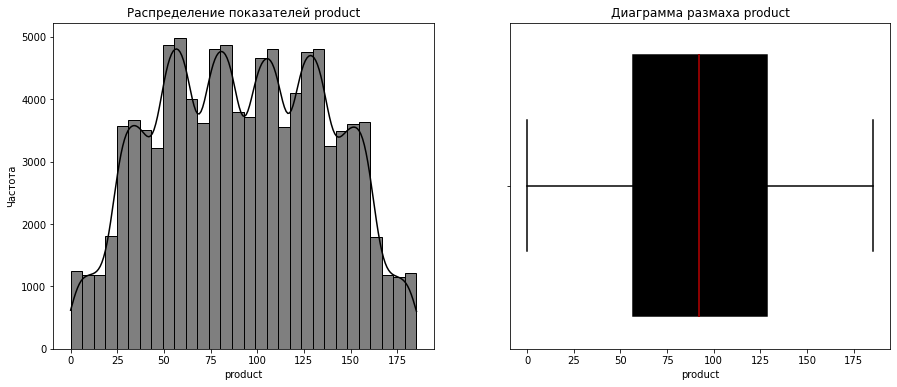

In [14]:
researchvis_num_features(region_0, ['product'], 'black')

#### f фичи для региона 0

In [15]:
num_col = ['f0', 'f1', 'f2']

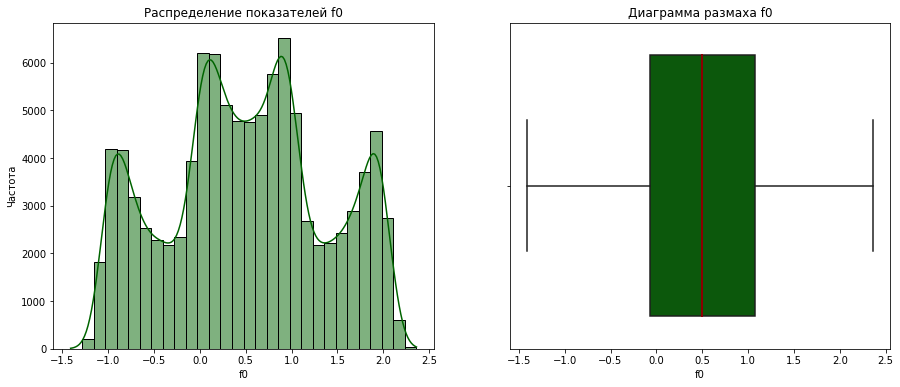

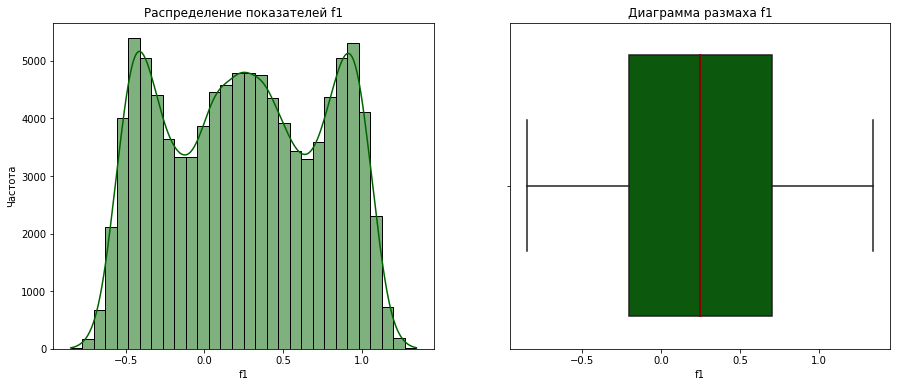

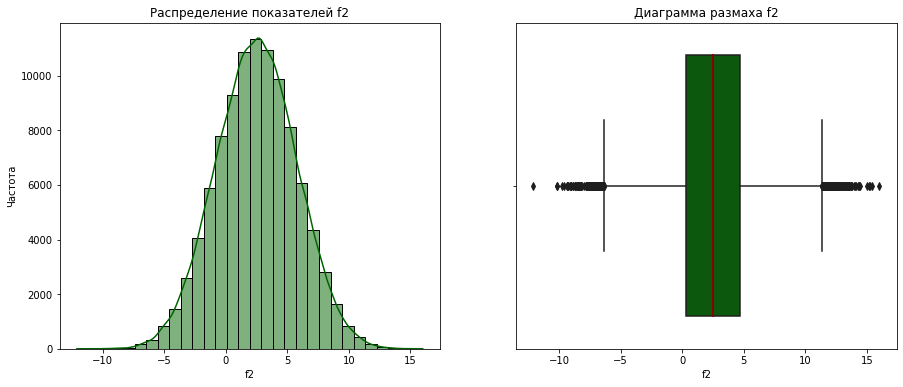

In [16]:
for i in num_col:
    researchvis_num_features(region_0, [i], 'darkgreen')

In [17]:
region_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


## Регион 2

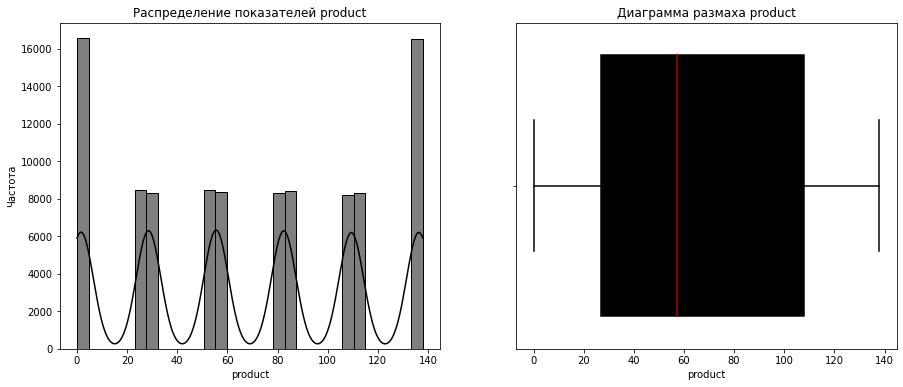

In [18]:
researchvis_num_features(region_1, ['product'], 'black')

#### f фичи для региона 1

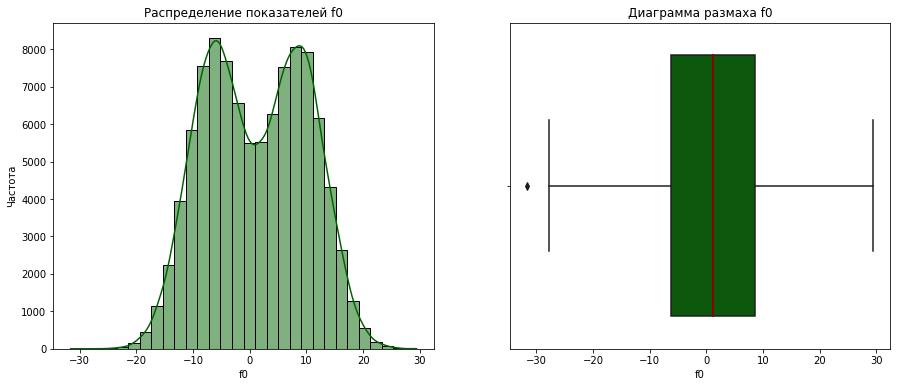

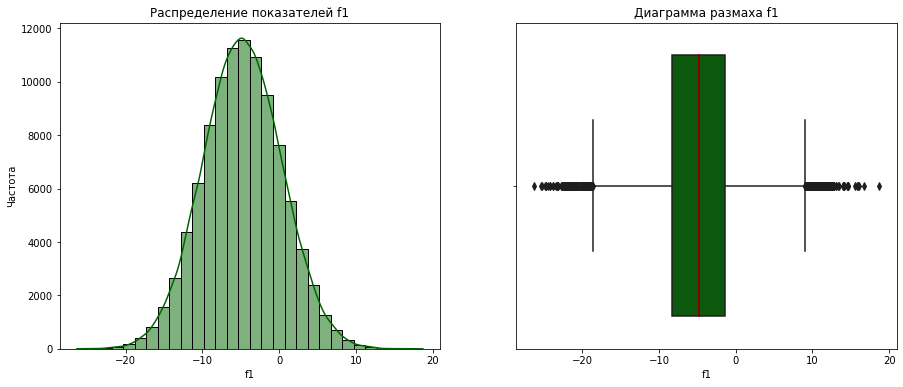

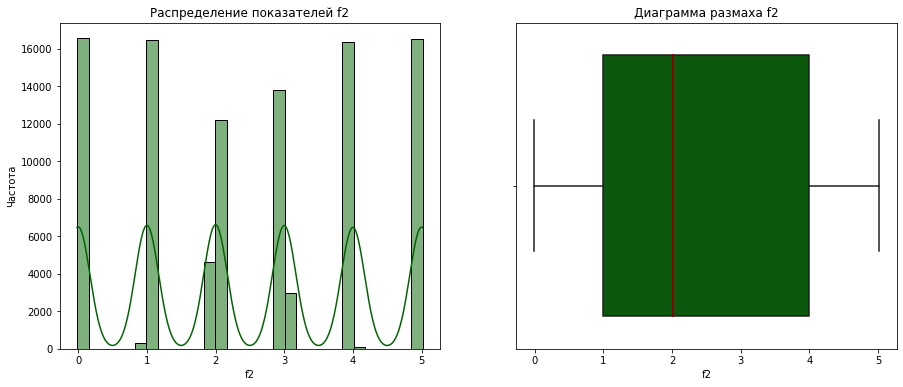

In [19]:
for i in num_col:
    researchvis_num_features(region_1, [i], 'darkgreen')

In [20]:
region_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


## Регион 2

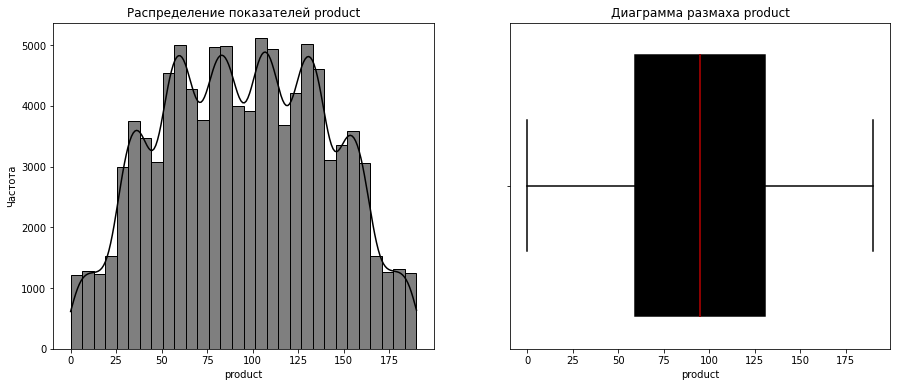

In [21]:
researchvis_num_features(region_2, ['product'], 'black')

#### f фичи для региона 2

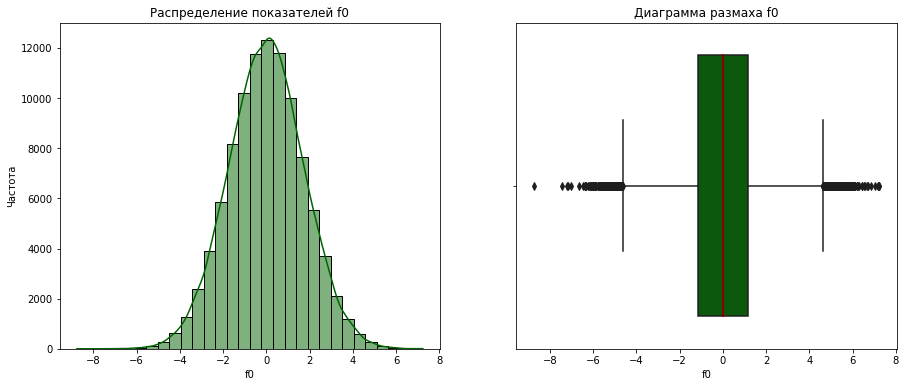

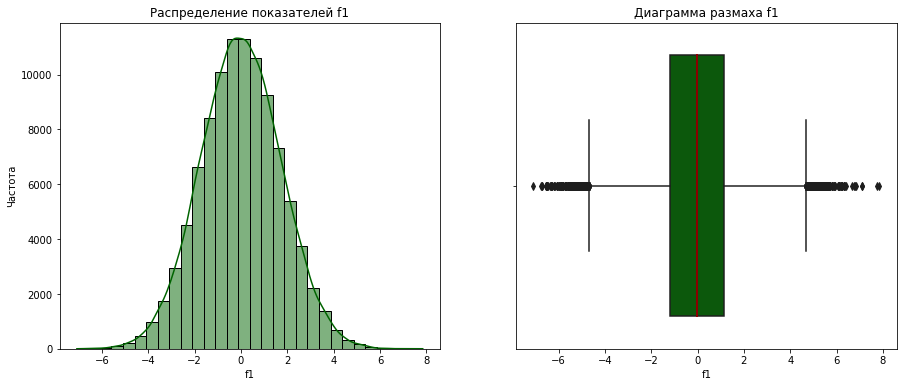

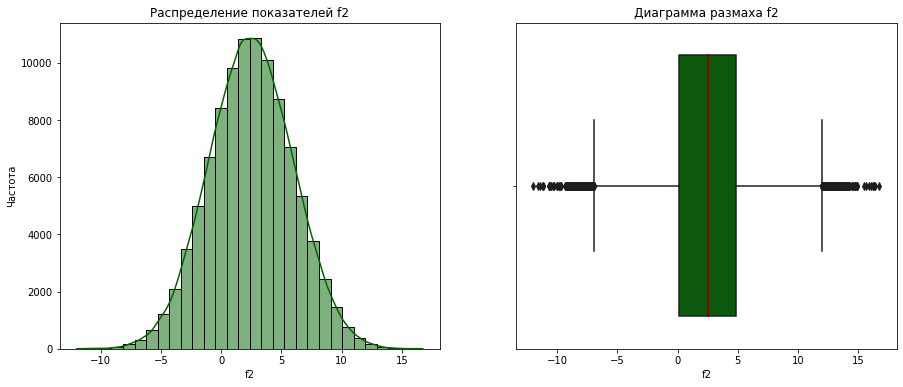

In [22]:
for i in num_col:
    researchvis_num_features(region_2, [i], 'darkgreen')

In [23]:
region_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


  Целевой признак(обьём нефтяных скважин в тыс баррелей)  в основном не вызывает подозрений, в регионах 0 и 2 распределение блиско к нормальному, разве что множество идентичных вершин вокруг центрального значения и отстутвие хвостов распределения. Вызывает вопросы регион 1. На гистограме видны явно не непрерывные величины, в основном данные сгруппированы около конкретных значений, а между ними с одним и тем же шагом идут разрывы. Складывается впечатление, что в регионе 1 были исследованы конкретные месторождения в количестве около 12. Из-за отстутвия единообразия, скорее всего адекватность прогнозов будет маловероятной. Это при том, что явнях дубликатов в данных нет вовсе.
 
  В основном коэффициэнты качества продукта в норме, выбросов нет, распределения либо нормальные, либо мультимодальные, что не критично. Из общей картины выбивается разве что признак f2 в регионе 1, он скорее имеет категориальное характер распределения, поскольку большинство величчин сгруппированы вокруг целых чисел, а между ними разрывы, в данном случае можно предположить, что этот признак заполнялся автоматически и заполнен сугубо синтетическими данными, что заметно снижает доверие к показателям из региона 1. Важно отметить, что каждый из f признаков это показатели качества нефти, содержание парафина, то насколько эта нефть легкая, скорее всего и геология региона, поскольку в разных регионах разная нефть и совсем разные условия добычи и совсем разные принимающие сырую нефть НПЗ.
  
  Однако регион 1 в отличие от остальных, может быть достаточно однородным, при условии, что геологию проводили на территории разных нефтяных бассейнов в регионе из-за чего множество данных имеют дискретный характер распределния.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно. Радует, что распределения были визуализированы!
</div>

## Обучение и проверка модели

In [24]:
def fill_predict(df, data_preprocessor):
    
    df = df.set_index('id')
    X = df.drop(['product'], axis=1)
    y = df['product']

    RANDOM_STATE = 42

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.25)
    
    model = LinearRegression(n_jobs=-1)
    
    X_train_prepare = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())

    X_valid_prepare = pd.DataFrame(data_preprocessor.transform(X_valid), columns=data_preprocessor.get_feature_names_out())
    
    model.fit(X_train_prepare, y_train)

    y_predict = model.predict(X_valid_prepare)
    
    y_predict = pd.DataFrame(y_predict, columns=['pred_prod'])
    y_predict['id'] = y_valid.index

    y_valid = y_valid.reset_index()
    X_valid = X_valid.reset_index()

    valid_sample_3 = X_valid.merge(y_valid, on='id', how='right')
    valid_sample_3 = valid_sample_3.merge(y_predict, on='id', how='left')
    
    return valid_sample_3
    

In [25]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(strategy='median')
        ),
        (
            'scaler', 
            MinMaxScaler()
        )
    ]
)

In [26]:
data_preprocessor = ColumnTransformer(
    
    [
        ('num', num_pipe, num_col)
    ],
    remainder='passthrough'

)

In [27]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [28]:
param_grid = [{
    
    'models': [LinearRegression(n_jobs=-1)],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}]

### REGION_0

In [29]:
def metrics(true, pred):
    
    print(f'Среднее: {pred.mean()}')
    print(f'RMSE: {root_mean_squared_error(true, pred)}')
    print(f'MSE: {mean_squared_error(true, pred)}')
    print(f'MAE: {mean_absolute_error(true, pred)}')
    

In [30]:
valid_sample_0 = fill_predict(region_0, data_preprocessor)
valid_sample_0.head()

,id,f0,f1,f2,product,pred_prod
0,7C6bA,0.599283,-0.557623,2.121187,122.073350,101.901017
1,dVxsn,0.739017,-0.463156,-1.347584,48.738540,78.217774
2,1Gm3l,1.422743,-0.534917,3.718798,131.338088,115.266901
3,Nzg1t,1.580244,-0.238458,2.805149,88.327757,105.618618
4,Z7b4F,0.918974,0.023961,2.598575,36.959266,97.980185


### Сравнение истинного обьема с предсказаннным по региону 0

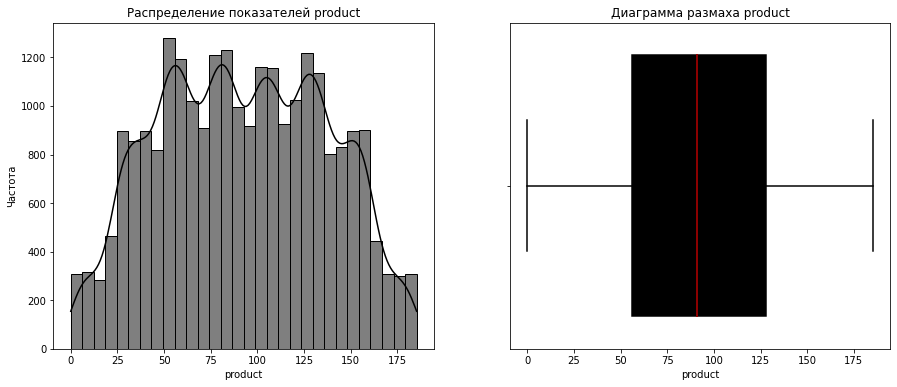

In [31]:
researchvis_num_features(valid_sample_0, ['product'], 'black')

None
Среднее: 92.39879990657768
RMSE: 37.75660035026169
MSE: 1425.5608700093812
MAE: 31.047681538788183


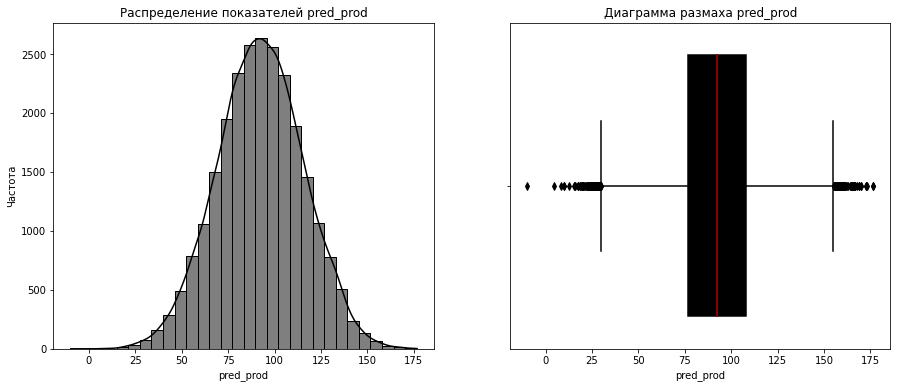

In [32]:
print(researchvis_num_features(valid_sample_0, ['pred_prod'], 'black'))
metrics(valid_sample_0["product"], valid_sample_0["pred_prod"])

### REGION_1

In [33]:
valid_sample_1 = fill_predict(region_1, data_preprocessor)
valid_sample_1.head()

,id,f0,f1,f2,product,pred_prod
0,fYVDK,6.078076,0.084568,0.002957,0.000000,0.844738
1,3SQcq,16.462386,2.712946,1.993030,53.906522,52.921612
2,hQ1gJ,7.051898,0.766983,4.990194,134.766305,135.110385
3,Y4vux,-0.240045,-0.380804,3.999693,107.813044,109.494863
4,H1NUw,13.350111,-8.558281,0.002010,0.000000,-0.047292


### Сравнение истинного обьема с предсказаннным по региону 1

None


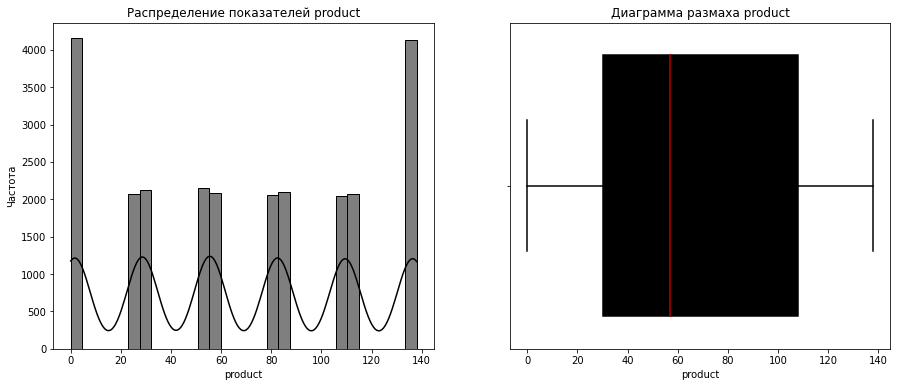

In [34]:
print(researchvis_num_features(valid_sample_1, ['product'], 'black'))

None
Среднее: 68.71287803913762
RMSE: 0.8902801001028844
MSE: 0.7925986566392018
MAE: 0.7170119535682555


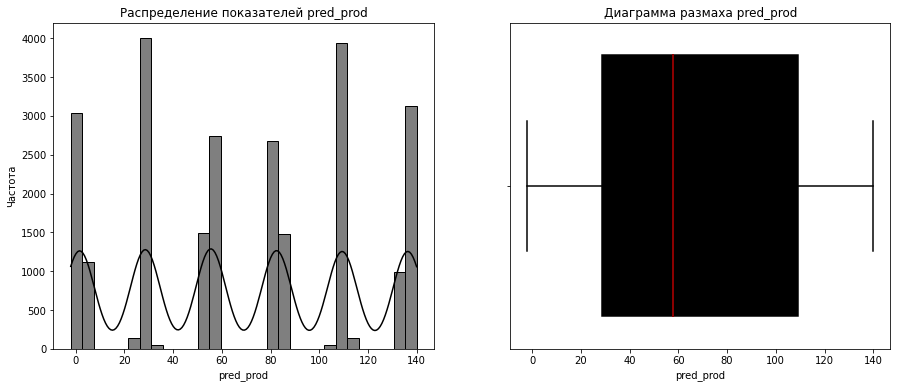

In [35]:
print(researchvis_num_features(valid_sample_1, ['pred_prod'], 'black'))
metrics(valid_sample_1["product"], valid_sample_1["pred_prod"])

### REGION_2

In [36]:
valid_sample_2 = fill_predict(region_2, data_preprocessor)
valid_sample_2.head()

,id,f0,f1,f2,product,pred_prod
0,sPjbT,2.111118,-1.679773,3.112240,117.441301,98.301916
1,1u4uo,0.734759,0.747788,3.670879,47.841249,101.592461
2,kZ6HO,-2.513109,0.844631,-4.922889,45.883483,52.449099
3,gCZGK,-2.035301,-1.522988,5.072839,139.014608,109.922127
4,rqJHx,2.744145,1.429952,-1.372661,84.004276,72.411847


### Сравнение истинного обьема с предсказаннным по региону 2

None


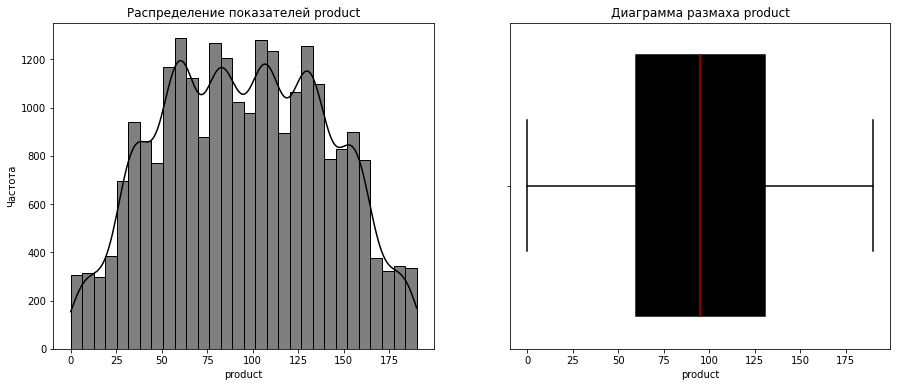

In [37]:
print(researchvis_num_features(valid_sample_2, ['product'], 'black'))

None
Среднее: 94.77102387765939
RMSE: 40.14587231134218
MSE: 1611.6910636385905
MAE: 32.896958610578054


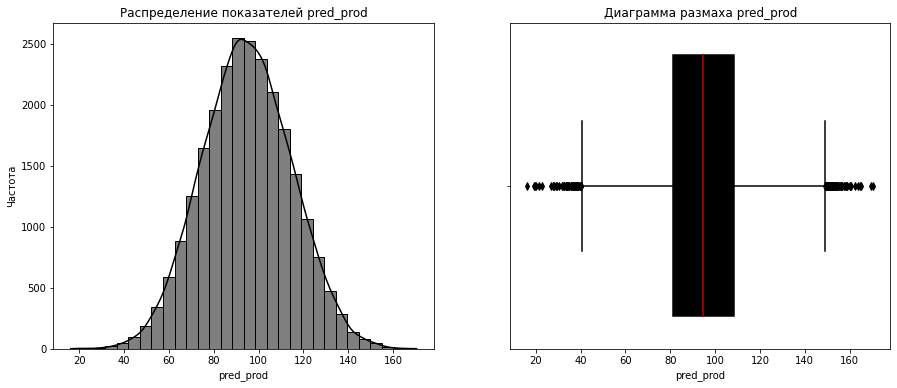

In [38]:
print(researchvis_num_features(valid_sample_2, ['pred_prod'], 'black'))
metrics(valid_sample_2["product"], valid_sample_2["pred_prod"])

 Выводы:
 
Регион 0:
         - Распределние предсказаний абсолютно нормальное
         - Средний обьём скважины 92 тыс баррелей
         - По RMSE 37, именно столько составляет погрешность прогноза
         
  Метрика RMSE отлично подходит для скоринга целевого признака т.к выбросов и аномальных значений обусловленных особенностью данных нет.       
         
Регион 1:
         - Распределние предсказаний абсолютно нормальное
         - Средний обьём скважины 68 тыс баррелей
         - По RMSE 0.8, именно столько составляет погрешность прогноза
         
 Средний показатель низкий из-за пробелов между показателями и слишком высокой общей скученности величин вокруг конкретных значений, которая только усугубляется по итогам прогноза. Погрешность крайне мала, по вышеуказанным причинам и в том числе из-за признака f2, который судя по всему имеет схожу природу с целевым признаком.         

Регион 2:
         - Распределние предсказаний абсолютно нормальное
         - Средний обьём скважины 95 тыс баррелей
         - По RMSE 42, именно столько составляет погрешность прогноза
         
 В общем большее доверие вызывают результаты полученные из региона 0, да в среднем в регионе 2 целевые показатели обьёма выше, но и погрешность в предсказаниях значительно больше. Полученные прогнозы по региону 1 низкие и на данном этапе не вызывают доверия.       
         

<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь функции. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

## Подготовка к расчёту прибыли

 На предыдущем этапе мы получили средние значения обьёма в скважинах. Теперь предстоит подсчитать выручку от их освоения.

In [39]:
budget = 10_000_000_000
revenue_stocks = 450_000
count_of_wells = 500
best_wells = 200

size_of_stocks = budget / (revenue_stocks * best_wells)
round(size_of_stocks, 2)

111.11

Как видно в итоге средний обьем скважины должен быть 111 тыс баррелей, для ведения безубыточной добычи, этот показатель уже выше среднего в каждом из регионов, а нам же и вовсе необходима маржинальность добычи с учетом настолько крупных вложений в разарботку месторождений.

<div class="alert alert-block alert-info">

<b>Совет: </b> В названиях константных переменных лучше использовать только БОЛЬШИЕ буквы. Это соглашение между программистами: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#id29 .
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> У тебя указано, что ТБ равна 44.44, а в выводы ты пишешь, что она равна 111. Какой из двух чисел корректно?
</div>

<b>Комментарий студента </b> Исправил
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

## Расчёт прибыли и рисков 

In [40]:
 def revenue_well (valid_sample):
    
    revenue_stocks = 450_000
    
    revenue_sum = round((valid_sample['pred_prod'].sum() * revenue_stocks / 10**9 - 10), 2)
    
    return revenue_sum

In [41]:
def revenue(true_pred_df, number_of_wells, rev_per_unit):
    sorted_df = true_pred_df.sort_values(by='pred_prod', 
                                         ascending= False)[:number_of_wells]    

    return sorted_df['product'].sum() * rev_per_unit -  budget

In [42]:
best_wells_reg_0 = valid_sample_0.sort_values(by='pred_prod', ascending=False)
best_wells_reg_0 = best_wells_reg_0.head(count_of_wells)
best_wells_reg_0.head()

,id,f0,f1,f2,product,pred_prod
6958,lfgbR,1.853784,-0.153503,13.585450,153.639837,176.536104
18194,WcCwe,1.723956,-0.376442,13.139065,140.631646,176.274510
17251,he3xS,0.370519,-0.283066,13.668868,178.879516,173.249504
457,kU92A,0.896968,-0.498996,12.828118,176.807828,172.802708
2202,2I3WV,1.114191,-0.217015,13.302975,130.985681,172.744977


In [43]:
best_wells_reg_0 = best_wells_reg_0.head(best_wells)
print(best_wells_reg_0['pred_prod'].head(best_wells).sum())
print(f'RMSE: {root_mean_squared_error(best_wells_reg_0["product"], best_wells_reg_0["pred_prod"])}')

30881.463288146988
RMSE: 25.419053601213736


In [44]:
best_wells_reg_1 = valid_sample_1.sort_values(by='pred_prod', ascending=False)
best_wells_reg_1 = best_wells_reg_1.head(count_of_wells)
best_wells_reg_1.head()

,id,f0,f1,f2,product,pred_prod
20776,kpPCd,-23.884180,-3.773158,5.001008,137.945408,139.983277
2323,vd9ik,-20.401677,-11.205156,5.003276,137.945408,139.700803
13895,a8qSM,-17.391679,-12.347464,5.015414,137.945408,139.616544
6950,1m8tG,-19.352200,-7.969103,5.004618,137.945408,139.514768
9151,55xmk,-19.963551,-3.719157,5.003169,137.945408,139.472212


In [45]:
best_wells_reg_1 = best_wells_reg_1.head(best_wells)
print(best_wells_reg_1['pred_prod'].head(best_wells).sum())
print(f'RMSE: {root_mean_squared_error(best_wells_reg_1["product"], best_wells_reg_1["pred_prod"])}')

27748.751366664626
RMSE: 0.8441311611602871


In [46]:
best_wells_reg_2 = valid_sample_2.sort_values(by='pred_prod', ascending=False)
best_wells_reg_2 = best_wells_reg_2.head(count_of_wells)
best_wells_reg_2.head()

,id,f0,f1,f2,product,pred_prod
21852,rtPef,-0.214989,1.849141,15.648691,101.225039,170.529209
10722,KJ6bS,0.517061,-2.686813,15.498363,151.655778,169.673332
6209,Jz7Ou,1.275966,-2.877779,14.748519,92.947333,165.300724
8203,yJO5k,-0.005191,-1.141924,14.614990,97.775979,164.613896
8042,bxRO7,-0.800689,-0.417209,14.492273,122.460897,163.964000


In [47]:
best_wells_reg_2 = best_wells_reg_2.head(best_wells)
print(best_wells_reg_2['pred_prod'].sum())
print(f'RMSE: {root_mean_squared_error(best_wells_reg_2["product"], best_wells_reg_2["pred_prod"])}')

29728.847808255443
RMSE: 31.082659674231


In [48]:

for i in range(3):
    
    df = globals()[f"best_wells_reg_{str(i)}"]
    
    print(f'Прогнозируемая чистая прибыль по региону {i}:', f'{revenue_well(df)} млрд рублей')
    
    print()
  

Прогнозируемая чистая прибыль по региону 0: 3.9 млрд рублей

Прогнозируемая чистая прибыль по региону 1: 2.49 млрд рублей

Прогнозируемая чистая прибыль по региону 2: 3.38 млрд рублей



Лидирует по величине чистой прибыли регион 0 с 3.9 млрд рублей. Рентабельнность относительно вложений составит 39 %, что является высоким показателем. Самая низкая чистая быль по региону 1, всего 2.49 млрд рублей, что естественно, потолок величин обьёма скважины там всего 139 тыс баррелей. Более скромные относительно первого региона значения чистой прибыли у региона 2, там она оставила 3.38 млрд рублей.

## Bootsrap

In [49]:
state = np.random.RandomState(43) 

def risk_revenue(valid_sample, count_wells, revenue_stocks):
    
    revenue_per_stock = []

    for i in range(1000):
        samples = valid_sample.sample(n=500, replace=True, random_state=state)
        revenue_sample = revenue(true_pred_df=samples, number_of_wells = count_wells, rev_per_unit = revenue_stocks)
        revenue_per_stock.append(revenue_sample)
        
    revenue_per_stock = pd.Series(revenue_per_stock) 

    mean_val_rev = round(revenue_per_stock.mean()/10**9, 2)

    risks = revenue_per_stock.loc[lambda x: x<0].count() / revenue_per_stock.count() * 100

    confidence_interval = ([revenue_per_stock.quantile(0.025), revenue_per_stock.quantile(0.975)],)

    return mean_val_rev, round(risks, 1), confidence_interval


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Для выбора 200 лучших скважин нужно использовать предсказанные значения. А вот для подсчета прибыли должны использоваться настоящие значения соответствующих ячеек.
</div>

<b>Комментарий студента </b> Исправлено, ошибку понял
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что для подсчета доверительного интервала использовался именно метод квантилей!
</div>


<div class="alert alert-block alert-info">

<b>Совет: </b> Риск можно было найти чуть проще: `(values < 0).mean()`, если объект типа pandas Series или numpy array.
</div>

In [50]:
for i in range(3):
    df = globals()[f'valid_sample_{i}']
    
    mean_val, risks, confidence_interval = risk_revenue(valid_sample=df, count_wells=200, revenue_stocks=revenue_stocks)
    
    print(f'Регион {i}')
    print()
    
    print(f'Cреднее значение положительной прибыли: {mean_val}')
    print(f'Риски в %: {risks}')
    print(f'Доверительный интервал 95%: {confidence_interval}')
    print()
    

Регион 0

Cреднее значение положительной прибыли: 0.42
Риски в %: 6.0
Доверительный интервал 95%: ([-128565818.00802688, 951859014.8233461],)

Регион 1

Cреднее значение положительной прибыли: 0.45
Риски в %: 2.0
Доверительный интервал 95%: ([16773090.128479246, 808768230.6111852],)

Регион 2

Cреднее значение положительной прибыли: 0.37
Риски в %: 9.2
Доверительный интервал 95%: ([-135677583.56364262, 837060643.9435066],)



  Как мы видим наилучшие результаты показал именно регион 1, лучшая чистая прибыль из всех, хоть и относительно низкая в целом - 0,45 млрд рублей, однако самый высокий риск из всех в 2 %, но всё же он не велик и не превышает обозначенный потолок в 2,5 %.
  
  В случае с регионами 0 и 2 дела обстоят несколько хуже. В регионе 0 прибыль составит 0,42 млрд рублей, что уже значительно ниже, при повышенном риске получить убытки в 6 %. В регионе 2 самая низкая прибыль, всего 0,37 млрд рублей и с самым высоким, недопустимым риском в 9,2 %.
  
  Следует выбрать регион 1, на протяжении всего исследовани и прогнозирования именно он показывал самые стабильные результаты, за счет крайне низкого разброса, хоть и с в среднем меньшим обьёмом, но с большим постоянством в величинах.   

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Теперь все статистики посчитаны корректно.
</div>

## Подведение итогов

 Можно подвести итоги проделанной работы. 
 
 С данными сложно работать, поскольку значимые коэффициэнты исследования по сути скрыты, трудно выстраивать между ними взаимосвязи и также трудно обьяснять те или иные паттерны их распредления, следовательно гарантировать точную интерпретируемость имеющихся у меня вводных я не могу. Я лишь предполагаю. В остальном, данные качественные, без пропусков и явных дубликатов, хоть и являются синтетическими.
 
 Оптималным обьемом скважины, для обеспечения безубыточной прибыли является точка в 111 тыс баррелей. Это значение уже существенно превышает среднее по всем трём регионам.
 
 Самую высокую чистую прибыль показали регионы 0 и 2 в 3,9 и 3,4 млрд рублей соответственно, однако качество прогнозов модели по датасетам с этими регионами крайне низкое. Гораздо лучше дела обстоят с регионом 1, предсказания практически не имеют прогноза, за счет предположительно ограниченного количества месторождений числом в 10-12, в котороых в последствии планируется бурение. Чистая прибыль составит 2,7 млрд и при этом она будет гарантированной, когда случае с регионами 0 и 2 можно ожидать сильную дивергенцию между прогнозом и действительностью не в пользу компании.  Шансы же получить куда меньшие обьемы нефти в месторождении заранее отмеченном, как прибыльное, куда выше в регионах 0 и 2. 
 
 Во всех регионах прослеживается низкая вероятность получить убытки, коя удовлетворяет критерии заказчика. Высокую среднюю положительную прибыль показал регион 1, в 0,45 млрд рублей, что значительно выше чем в остальных регионах, при сохранении низкой вероятности убытков, которую вовсе не могут обеспечить регионы 0 и 2. 
 
С учетом всего вышесказанного следует выбрать регион 1, как самый надёжный.
 

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> С выбором региона согласен.
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован